In [176]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainty_utils import *
import controlpy
import tqdm
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=16)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

### Problem setup
Assume the following state space model:
$$ x_{k+1} = Ax_k + Bu_k + w_k $$
With known noise covariance, and known initial state. We have an initial guess of the system dynamics: 
$$ A_{init} = A + \Delta^A, \\ B_{init} = B + \Delta^B  $$
With the estimated dynamics, we synthesize an infinite horizon LQR controller, which we use for control for a fixed amount of time. When the finite length horizon terminates, we create new estimates of the dynamics from the state-input trajectory as follows:
$$ A^*, B^*\min_{A,B} \sum_{i=0}^{N-1} ||A\hat{x}_i + Bu_i - \hat{x}_{i+1}||_2^2 + \lambda||[A, B]||_F^2$$
 We synthesize a new LQR controller, and perform another episode of control with the new system id, and analyze the convergence of the estimates and trajectories. 

In [214]:
# Dynamics
A_true = np.array([[1,.1],[0,1]])
B_true = np.array([0,1]).reshape((2,1))
N = A_true.shape[0]
M = B_true.shape[1]
x_init = np.array([5, 2])
input_limits = 2 * np.array([-1,1])

# LQR Cost:
Q = np.eye(N)
R = np.eye(M)

# Estimation and Simulation
process_noise_var = 5e-2
process_noise = process_noise_var * np.eye(N)

# Experiment details
num_iterations = 1000
regularization = 1e-8
episode_length = 200
num_data_points = 10
id_noise_std = 1e-2
sigma_init_id_error = 5e-2
create_animation = False
save_figs = True
save_dir = "model_lqr_expts_3/"

def sim_traj(A, B, K, Q, R, process_noise, x_init, N=50, input_limits=np.array([-1e9, 1e9]), W=None, input_noise=0):
    x_traj = [x_init]
    u_traj = []

    h = lambda x,u: x.T @ Q @ x + u.T @ R @ u
    cost = 0
    
    input_noises = np.random.randn(R.shape[0], N) * input_noise if input_noise > 0 else np.zeros((R.shape[0], N))
    
    for i in range(N):
        u = np.minimum(np.maximum(input_limits[0], - K @ x_traj[-1]), input_limits[1]) + input_noises[:,i]
        w = W[i,:] if W is not None else np.random.multivariate_normal(np.zeros(x_init.shape[0]), process_noise)
        x_next = A @ x_traj[-1] + B @ u + w
        cost += h(x_traj[-1], u)

        x_traj.append(x_next)
        u_traj.append(u)
    return np.array(x_traj), np.array(u_traj), cost

def is_stable(A):
    return np.all(np.abs(np.linalg.eigvals(A)) < 1)

## Constants

In [215]:
TRAJ_CE = "state traj ce"
INPUT_TRAJ_CE = "input trajectory ce"

TRAJ_STOCH = "state traj stoch"
INPUT_TRAJ_STOCH = "input trajectory stoch"

COST_CE = "cost certainty equivalence"
COST_STOCH = "cost stochastic"

ERROR = "regression error"
COV = "covariance"
A_EST = "A_est"
B_EST = "B_est"

GAIN_CE = "K_ce"
GAIN_STOCH = "K_stoch"

STABLE_CE = "stable ce"
STABLE_STOCH = "stable stoch"

CONVERGED = "converged"

def init_experiment():
    data = {}
    data[TRAJ_CE] = []
    data[INPUT_TRAJ_CE] = []
    
    data[TRAJ_STOCH] = []
    data[INPUT_TRAJ_STOCH] = []
    
    data[COST_CE] = []
    data[COST_STOCH] = []
    
    data[ERROR] = [0]
    data[COV] = [sigma_init_id_error * np.eye(N + M)]
    data[A_EST] = []
    data[B_EST] = []
    data[GAIN_CE] = []
    data[GAIN_STOCH] = []
    data["process noise variance"] = process_noise_var
    data[STABLE_CE] = []
    data[STABLE_STOCH] = []
    data[CONVERGED] = []
    return data

### Show an initial run with the true dynamics

In [216]:
K_opt, _, _= controlpy.synthesis.controller_lqr_discrete_time(A_true, B_true, Q, R)
def get_true_trajectory(episode_length):
    x_init_sim = x_init + np.random.multivariate_normal(np.zeros(N), process_noise)
    x_traj, u_traj, true_opt_cost = sim_traj(A_true, B_true, K_opt, Q, R, process_noise, x_init_sim, N=episode_length, input_limits=input_limits, input_noise=id_noise_std)
    return x_traj, u_traj, true_opt_cost

In [217]:
true_lqr_costs = []
for i in tqdm.tqdm(range(num_iterations)):
    x_init_sim = x_init #+ np.random.multivariate_normal(np.zeros(N), process_noise)
    x_traj, u_traj, true_opt_cost = sim_traj(A_true, B_true, K_opt, Q, R, process_noise, x_init_sim, N=episode_length)
    true_lqr_costs.append(true_opt_cost)

print(np.mean(true_lqr_costs))


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.31it/s]


478.3955795703698


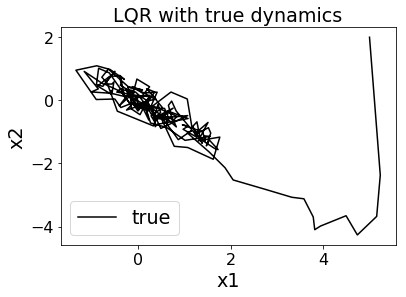

In [218]:
plt.plot(x_traj[:,0], x_traj[:,1],'k')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("LQR with true dynamics")
plt.legend(("true", "estimated"))

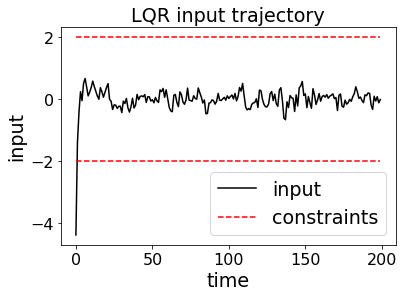

In [219]:
plt.plot(u_traj, "k")
plt.plot(np.ones(len(u_traj)) * input_limits[0], "r--")
plt.plot(np.ones(len(u_traj)) * input_limits[1], "r--")
plt.xlabel("time")
plt.ylabel("input")
plt.title("LQR input trajectory")
plt.legend(("input", "constraints"))

## Setup Ricatti Solvers

In [220]:
# data = init_experiment()
A_est = A_true + sigma_init_id_error * np.random.randn(N,N) * process_noise_var
B_est = B_true + sigma_init_id_error * np.random.randn(N,M) * process_noise_var

x_init_true = x_init + np.random.multivariate_normal(np.zeros(N), process_noise)

K, _, _= controlpy.synthesis.controller_lqr_discrete_time(A_est, B_est, Q, R)


In [221]:
def iterate_are(P_next, A_hat, B_hat, Q, R, S, model_cov, sigma_w, lr=1):
    n = A_hat.shape[0]
    m = B_hat.shape[1]
    Q_hat = model_cov[:n,:n]
    R_hat = model_cov[n:,n:]
    S_hat = model_cov[:n, n:]
    gamma = np.trace(P_next @ sigma_w)
    F = - np.linalg.inv(R + gamma * R_hat + B_hat.T @ P_next @ B_hat) @  (S.T  + gamma * S_hat.T +  B_hat.T @ P_next @ A_hat)
    P_curr = Q + gamma * Q_hat - (S + gamma * S_hat + A_hat.T @ P_next @ B_hat) @ np.linalg.inv(R + gamma * R_hat + B_hat.T @ P_next @ B_hat) @ (S.T + gamma * S_hat.T + B_hat.T @ P_next @ A_hat) + A_hat.T @ P_next @ A_hat
    P_curr = lr * P_curr + (1 - lr) * P_next
    return P_curr, F

def solve_mod_are(A_hat, B_hat, Q, R, model_cov, sigma_w, tol=1e-10, max_iter=500):
    S = np.zeros((Q.shape[0], R.shape[0]))
    P = scipy.linalg.solve_discrete_are(A_hat, B_hat, Q, R,s=S)
    converged = False
    P_curr = P
    for i in range(max_iter):
        P_curr, F = iterate_are(P, A_hat, B_hat, Q, R, S, model_cov, sigma_w)
        if np.linalg.norm(P - P_curr) <= tol:
            converged = True
            break
        P = P_curr
    return P, F, converged

## Show solver converges

In [222]:
K_lqr, P_ce, _ = controlpy.synthesis.controller_lqr_discrete_time(A_est, B_est, Q, R)
Ps = [P_ce]
Fs = []
num_its = 500
S = np.zeros((Q.shape[0], R.shape[0]))
for i in range(num_its):
    P_curr, F_curr = iterate_are(Ps[-1], A_est, B_est, Q, R, S, data[COV][0], process_noise)
    Ps.append(P_curr)
    Fs.append(F_curr)
P_stoch = Ps[-1]
PP, F, conv = solve_mod_are(A_est, B_est, Q, R, data[COV][0], process_noise)
print(np.linalg.norm(PP - P_stoch))
print(np.linalg.norm(P_ce - PP), np.linalg.norm(K + F))

5.508752623775897e-10
0.4226516402739496 2.639402399070191e-11


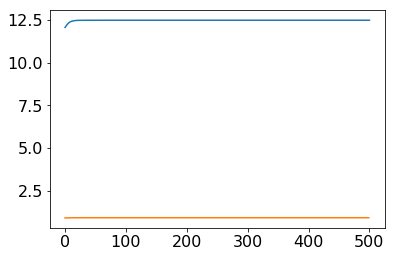

In [223]:
P_norms = [np.linalg.norm(P) for P in Ps]
F_norms = [np.linalg.norm(F) for F in Fs]
plt.plot(P_norms)
plt.plot(F_norms)

### Run iterative LQG + system ID

In [224]:
def run_experiment(num_data_pts, cov_multiplier=1):
    data = init_experiment()

    for _ in tqdm.tqdm(range(num_iterations)):
        x_traj_id, u_traj_id, cost_id = get_true_trajectory(num_data_pts)
        
        A_est, B_est, cov, error = single_traj_regression(x_traj_id, u_traj_id, regularization)

        x_init_sim = x_init + np.random.multivariate_normal(np.zeros(N), process_noise)
        K_ce, P_ce, _= controlpy.synthesis.controller_lqr_discrete_time(A_est, B_est, Q, R)
        P_stoch, F, converged = solve_mod_are(A_est, B_est, Q, R, cov_multiplier * cov, process_noise)

        W = np.random.multivariate_normal(np.zeros(x_init.shape[0]), process_noise, size=episode_length)
        x_traj_ce, u_traj_ce, cost_ce = sim_traj(A_true, B_true, K_ce, Q, R, process_noise, x_init_sim,
                                                        N=episode_length, W=W)
        data[COST_CE].append(cost_ce)
        data[STABLE_CE].append(is_stable(A_true - B_true @ K_ce))
        data[CONVERGED].append(converged)
        data[TRAJ_CE].append(x_traj_ce)
        data[INPUT_TRAJ_CE].append(u_traj_ce)
        data[COV].append(cov)
        data[ERROR].append(error)
        data[A_EST].append(A_est)
        data[B_EST].append(B_est)
        data[GAIN_CE].append(K_ce)
        if converged:
            K_stoch = -F
            x_traj_stoch, u_traj_stoch, cost_stoch = sim_traj(A_true, B_true, K_stoch, Q, R, process_noise, x_init_sim,
                                                        N=episode_length, W=W)

            data[COST_STOCH].append(cost_stoch)
            data[GAIN_STOCH].append(K_stoch)
            data[TRAJ_STOCH].append(x_traj_stoch)
            data[INPUT_TRAJ_STOCH].append(u_traj_stoch)
            data[STABLE_STOCH].append(is_stable(A_true - B_true @ K_stoch))
            
    return data

In [225]:
data = run_experiment(num_data_points, cov_multiplier=1)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 47.84it/s]


## Plot results

mean CE cost: 581295521959278208.000000, standard dev: 17319726690176028672.000000, percent stable: 0.820000
mean STOCH cost: 679310486774294.000000, standard dev: 15282379368740926.000000, percent stable: 0.846000


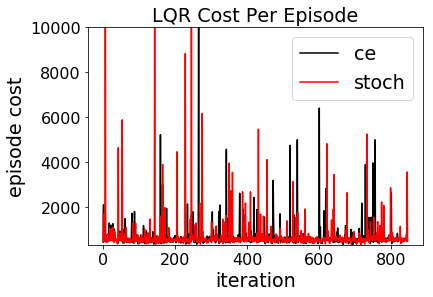

In [226]:
plt.plot(np.array(data[COST_CE])[data[STABLE_CE]], 'k')
plt.plot(np.array(data[COST_STOCH])[data[STABLE_STOCH]], "r")
# plt.plot(true_opt_cost * np.ones(num_iterations), "b")
plt.xlabel("iteration")
plt.ylabel("episode cost")
plt.title("LQR Cost Per Episode")
plt.legend(("ce", "stoch", "true LQR optimal"))
plt.ylim((300,10000))
print("mean CE cost: %f, standard dev: %f, percent stable: %f" % (np.mean(data[COST_CE][1:]), np.std(data[COST_CE][1:]), np.sum(data[STABLE_CE])/ len(data[STABLE_CE])))
print("mean STOCH cost: %f, standard dev: %f, percent stable: %f" % (np.mean(data[COST_STOCH]), np.std(data[COST_STOCH]), np.sum(data[STABLE_STOCH])/ len(data[STABLE_STOCH])))

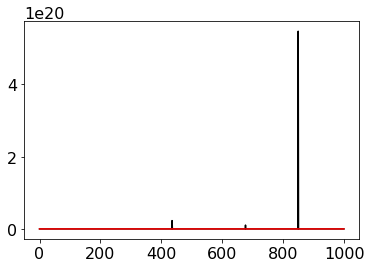

In [227]:
plt.plot(np.array(data[COST_CE])[data[CONVERGED]], 'k')
plt.plot(np.array(data[COST_STOCH]), "r")
# plt.ylim((1000,5000))

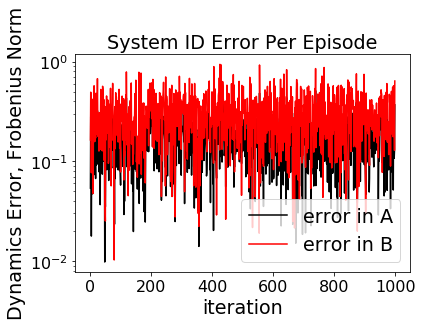

In [228]:
A_error = [np.linalg.norm(A_est - A_true) for A_est in data[A_EST]]
B_error = [np.linalg.norm(B_est - B_true) for B_est in data[B_EST]]
plt.semilogy(A_error, "k")
plt.semilogy(B_error, "r")
plt.xlabel("iteration")
plt.ylabel("Dynamics Error, Frobenius Norm")
plt.title("System ID Error Per Episode")
plt.legend(("error in A", "error in B"))

Text(0.5,1,'RMSE of Sys ID Per Episode')

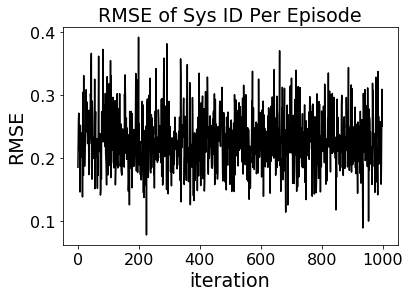

In [229]:
est_errors = [np.mean(np.linalg.norm(err, axis=1)) for err in data[ERROR][1:]]
plt.plot(est_errors,"k")
plt.xlabel("iteration")
plt.ylabel("RMSE")
plt.title("RMSE of Sys ID Per Episode")

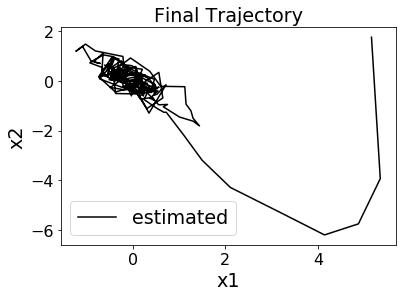

In [230]:
traj = data[TRAJ_CE][902]
plt.plot(traj[:,0], traj[:,1], "k")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Final Trajectory")
plt.legend(("estimated", "true"))

In [231]:
np.where(np.logical_and(np.array(data[COST_CE]) > 8000, data[STABLE_CE]))

(array([325], dtype=int64),)

## RUN Multiple Experiments

In [232]:
num_samples = 15
sample_sizes = np.logspace(0,3, num=num_samples, dtype=int)
sample_sizes = sample_sizes[sample_sizes > 3]
exp_data = [run_experiment(num_data_points, cov_multiplier=1) for num_data_points in sample_sizes]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:06<00:00,  5.37it/s]


In [233]:
if save_figs:
    np.savez(save_dir + "low_noise_constr_data.npz", exp_data=exp_data)

## Plot results

In [254]:
figsize = (8,5)
def pct_stable(data):
    pct_ce = np.sum(data[STABLE_CE])/ len(data[STABLE_CE])
    pct_stoch = np.sum(data[STABLE_STOCH])/ len(data[STABLE_STOCH])
    return pct_ce, pct_stoch
    
def plot_with_bars(x, y, color="b", alpha=0.3, loglog=False):
    means, hi, lo = zip(*[(np.mean(yi), np.max(yi), np.min(yi)) if len(yi)>0 else (np.nan, np.nan, np.nan) for yi in y])
    if loglog:
        plt.loglog(x,means,color)
    else:
        plt.plot(x, means, color)
    plt.fill_between(x, hi, lo, color=color, alpha=alpha)
    
def plot_with_bars_qts(x, y, color="b", alpha=0.3, loglog=False):
    means, hi, lo = zip(*[(np.quantile(yi,0.5), np.quantile(yi,0.25), np.quantile(yi,0.75)) if len(yi)>0 else (np.nan, np.nan, np.nan) for yi in y])
    if loglog:
        plt.loglog(x,means,color)
    else:
        plt.plot(x, means, color)
    plt.fill_between(x, hi, lo, color=color, alpha=alpha)
    
def plot_with_bars_sd(x, y, color="b", alpha=0.3):
    means, stds = zip(*[(np.mean(yi), np.std(yi)) if len(yi)>0 else (np.nan, np.nan, np.nan) for yi in y])
    means = np.array(means)
    stds = np.array(stds)
    plt.plot(x, means, color)
    hi = means + 2 * stds
    lo = np.maximum(means - 2 * stds,0)
    plt.fill_between(x, hi, lo, color=color, alpha=alpha)
    
stable_ce, stable_stoch = zip(*[pct_stable(d) for d in exp_data])

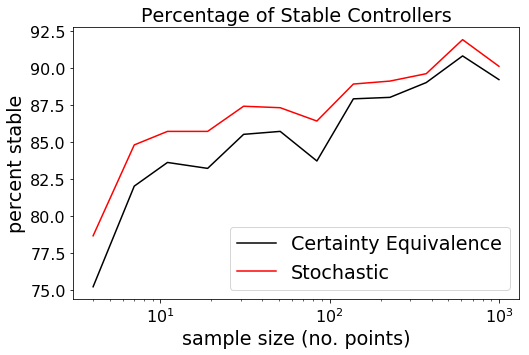

In [255]:
plt.figure(figsize=figsize)
plt.semilogx(sample_sizes[:], np.array(stable_ce) * 100, "k")
plt.semilogx(sample_sizes[:], np.array(stable_stoch) * 100, "r")
plt.xlabel("sample size (no. points)")
plt.ylabel("percent stable")
plt.title("Percentage of Stable Controllers")
plt.legend(("Certainty Equivalence","Stochastic"))
if save_figs:
    plt.savefig(save_dir + "low_noise_constr_percents.png")

In [257]:
def get_costs(data):
    return data[COST_CE], data[COST_STOCH]

def get_stable_costs(data):
    return np.array(data[COST_CE])[data[STABLE_CE]], np.array(data[COST_STOCH])[data[STABLE_STOCH]]

costs_ce, costs_stoch = zip(*[get_costs(d) for d in exp_data])
stable_costs_ce, stable_costs_stoch = zip(*[get_stable_costs(d) for d in exp_data])

478.3955795703698


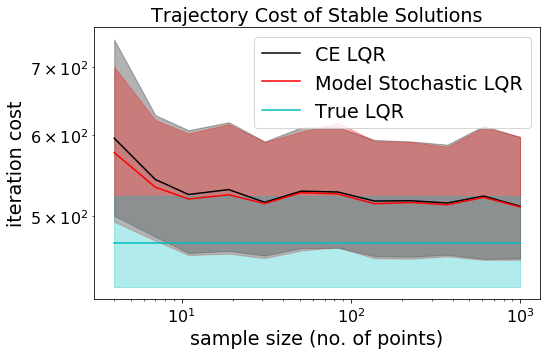

In [258]:
plt.figure(figsize=figsize)
plot_with_bars_qts(sample_sizes[:],stable_costs_ce,"k",loglog=True)
plot_with_bars_qts(sample_sizes[:], stable_costs_stoch, "r", loglog=True)
plot_with_bars_qts(sample_sizes[:], [true_lqr_costs]*len(sample_sizes),"c", loglog=True)
plt.ylabel("iteration cost")
plt.xlabel("sample size (no. of points)")
plt.title("Trajectory Cost of Stable Solutions")
plt.legend(("CE LQR", "Model Stochastic LQR", "True LQR"))
if save_figs:
    plt.savefig(save_dir + "low_noise_constr_traj_costs.png")
# plt.ylim((0,4000))
print(np.mean(true_lqr_costs))

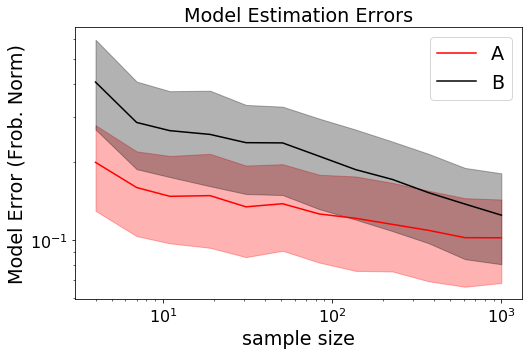

In [259]:
# data = np.load(save_dir + "low_noise_constr_data.npz", allow_pickle=True)
plt.figure(figsize=figsize)
A_errors = [[np.linalg.norm(A_true - A_est) for A_est in d[A_EST]]for d in exp_data]
B_errors = [[np.linalg.norm(B_true - B_est) for B_est in d[B_EST]]for d in exp_data]
plot_with_bars_qts(sample_sizes[:], A_errors, "r", loglog=True)
plot_with_bars_qts(sample_sizes[:], B_errors, "k", loglog=True)
plt.xlabel("sample size")
plt.ylabel("Model Error (Frob. Norm)")
plt.title("Model Estimation Errors")
plt.legend(("A", "B"))
if save_figs:
    plt.savefig(save_dir + "low_noise_constr_model_errs.png")

## DATA with COV x 100

In [239]:
exp_data_x = [run_experiment(num_data_points, cov_multiplier=100) for num_data_points in sample_sizes[:]]
if save_figs:
    np.savez(save_dir + "low_noise_constr_data_x.npz", exp_data=exp_data_x)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:26<00:00,  4.85it/s]


In [267]:
stable_ce, stable_stoch = zip(*[pct_stable(d) for d in exp_data_x])
print([np.sum(d[CONVERGED])for d in exp_data_x])
print(sample_sizes)

C:\Users\rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


[0, 608, 983, 999, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
[   4    7   11   19   31   51   84  138  227  372  610 1000]


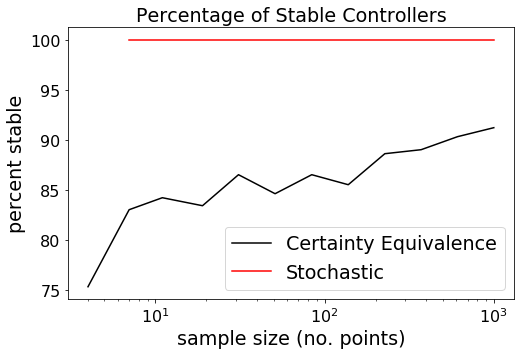

In [261]:
plt.figure(figsize=figsize)
plt.semilogx(sample_sizes[:], np.array(stable_ce) * 100, "k")
plt.semilogx(sample_sizes[:], np.array(stable_stoch) * 100, "r")
plt.xlabel("sample size (no. points)")
plt.ylabel("percent stable")
plt.title("Percentage of Stable Controllers")
plt.legend(("Certainty Equivalence","Stochastic"))
if save_figs:
    plt.savefig(save_dir + "low_noise_constr_percents_x.png")

C:\Users\rohan\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


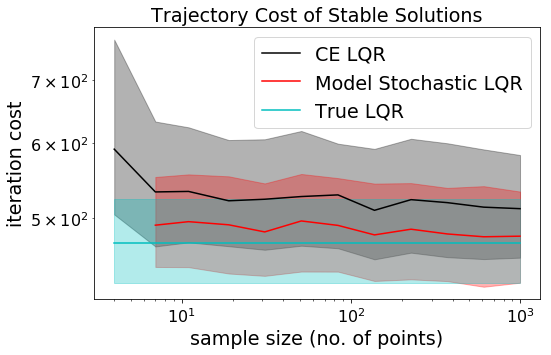

In [262]:
stable_costs_ce, stable_costs_stoch = zip(*[get_stable_costs(d) for d in exp_data_x])

plt.figure(figsize=figsize)
plot_with_bars_qts(sample_sizes[:],stable_costs_ce,"k",loglog=True)
plot_with_bars_qts(sample_sizes[:], stable_costs_stoch, "r", loglog=True)
plot_with_bars_qts(sample_sizes[:], [true_lqr_costs]*len(sample_sizes),"c", loglog=True)
plt.ylabel("iteration cost")
plt.xlabel("sample size (no. of points)")
plt.title("Trajectory Cost of Stable Solutions")
plt.legend(("CE LQR", "Model Stochastic LQR", "True LQR"))
if save_figs:
    plt.savefig(save_dir + "low_noise_constr_traj_costs_x.png")
# plt.ylim((0,4000))
# plt.ylim((0,4000))

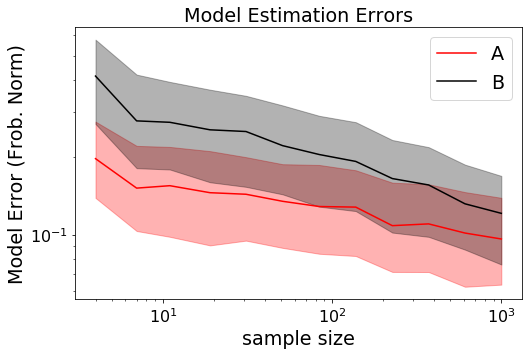

In [263]:
A_errors = [[np.linalg.norm(A_true - A_est) for A_est in d[A_EST]]for d in exp_data_x]
B_errors = [[np.linalg.norm(B_true - B_est) for B_est in d[B_EST]]for d in exp_data_x]
plt.figure(figsize=figsize)
plot_with_bars_qts(sample_sizes, A_errors, "r", loglog=True)
plot_with_bars_qts(sample_sizes, B_errors, "k", loglog=True)
plt.xlabel("sample size")
plt.ylabel("Model Error (Frob. Norm)")
plt.title("Model Estimation Errors")
plt.legend(("A", "B"))
if save_figs:
    plt.savefig(save_dir + "low_noise_constr_model_errs_x.png")

In [265]:
costs_x_mean = [np.mean(np.array(d[COST_STOCH])[d[STABLE_STOCH]]) for d in exp_data_x]
costs_mean = [np.mean(np.array(d[COST_STOCH])[d[STABLE_STOCH]]) for d in exp_data]

C:\Users\rohan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\rohan\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


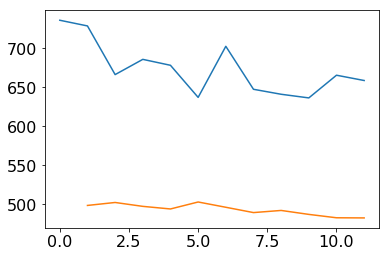

In [266]:
plt.plot(costs_mean)
plt.plot(costs_x_mean)

In [171]:
len(stable_costs_ce)

16

In [172]:
len(exp_data_x)

16

In [174]:
a = []
for n in np.arange(1e9):
    a.append(a)
    

KeyboardInterrupt: 

In [175]:
a

[]